In [1]:
from scipy import stats
import itertools

Functions

In [2]:
def rates_from_tree(tree):
    '''Extracts rates for each species in nwk tree'''
    tree = tree.replace("(","").replace(")","")
    subs_per_sp = {sp.split(":")[0]:float(sp.split(":")[1]) for sp in tree.split(",")}
    return subs_per_sp

def extract_sp_class(df, species, mutclass, chrom):
    subd = subclass_rates[(subclass_rates.species==species) 
                          & (subclass_rates.mutclass==mutclass)]
    if chrom!=None:
        subd = subd[subd.chromosome==chrom]
    subd = subd.reset_index(drop=True)
    return subd

Read input data

In [3]:
file_rates = "../scripts/merged_features/Mammals.Homo_sapiens.features.txt.gz"
size_limit = 10e3
chrX = "chrX"

rates = pd.read_csv(file_rates,compression="gzip",sep="\t")
rates = rates[(~rates.tree.isna()) & (rates.size >= size_limit)].reset_index(drop=True)
rates["tree_X>X"] = rates.tree
rates["tree_X"] = rates["size"]

All substitutions

In [16]:
sub_rates = pd.DataFrame([rates_from_tree(t) for t in rates.tree])
extra_cols = rates[["chrom","start","end"] + [c for c in rates.columns if "gc" in c]]
s = pd.concat([extra_cols, sub_rates], axis=1)

In [56]:
def distance(r1, r2):
    x, y = sorted((r1, r2))
    if x[0] <= x[1] < y[0] and all( y[0] <= y[1] for y in (r1,r2)):
        return y[0] - x[1]
    return 0

In [72]:
ampli = pd.read_csv("../regions/Homo_sapiens/X_escape-inactivation_hg38.bed",sep="\t",header=None)
ampli.columns = ["chrom","start","end"]

In [73]:
subd = data=s[s.chrom==chrom]

In [74]:
subd["inactivation"] = [any(distance([r.start,r.end],[r2.start,r2.end])==0 for i,r2 in ampli.iterrows()) for i,r in subd.iterrows()]

<ipython-input-74-63af0adb2ed3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subd["inactivation"] = [any(distance([r.start,r.end],[r2.start,r2.end])==0 for i,r2 in ampli.iterrows()) for i,r in subd.iterrows()]


<AxesSubplot:xlabel='start', ylabel='Homo_sapiens'>

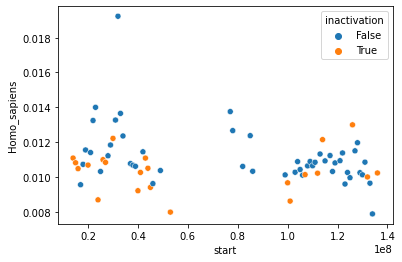

In [76]:
sp = "Homo_sapiens"
sns.scatterplot(data=subd, x="start".format(sp), y=sp, hue="inactivation")

Transform input into dataframe with rate of substitutions for each mutation type in each species

In [5]:
types = [c.split("_")[-1] for c in rates.columns if "tree_" in c and "var" not in c and ">" in c] + ["X>X"]
subclass = []
for i,r in rates.iterrows():
    n_changes = {mut:rates_from_tree(r["tree_{}".format(mut)]) for mut in types}
    n_substrate = {mut:rates_from_tree(r["tree_{}".format(mut)]) for mut in ["C","T"]}
    for k,changes in n_changes.items():
        anc = k.split(">")[0]
        for sp,n in changes.items():
            substrate = n_substrate[anc][sp] if anc in n_substrate else 1
            new_row = ["A" if r.chrom!="chrX" else "X",r.chrom, r.start, sp, r["{}-gc".format(sp)], n/substrate,r["size"],substrate,k]
            subclass.append(new_row)
subclass_rates = pd.DataFrame(subclass)
subclass_rates.columns = ["chromosome_type","chromosome","position","species","gc","rate","total_size","substrate","mutclass"]
subclass_rates = subclass_rates[subclass_rates.total_size>=10e3].reset_index(drop=True)

Normalize by weighted mean of each class in each species

In [291]:
mean_rates = subclass_rates.groupby(["species","mutclass"]).apply(lambda x: np.average(x["rate"],weights=x["substrate"])).to_dict()
subclass_rates["norm_rate"] = [r["rate"]/mean_rates[(r.species,r.mutclass)] for i,r in subclass_rates.iterrows()]
subclass_rates["id"] = subclass_rates["chromosome"] + ":" + [str(p) for p in subclass_rates["position"]]

In [355]:
sq_list = []
for (window,mut),df in subclass_rates.groupby(["id","mutclass"]):
    sq_list.append(list(df.norm_rate)+[mut,window])
sq_subclass_rates = pd.DataFrame(sq_list)
sq_subclass_rates.columns = list(species) + ["mutclass", "id"]
sq_subclass_rates = sq_subclass_rates[[all(r[species] < 10) for i,r in sq_subclass_rates.iterrows()]]

In [360]:
subclass_rates[subclass_rates.norm_rate>50]

,chromosome_type,chromosome,position,species,gc,rate,total_size,substrate,mutclass,norm_rate,id
323256,A,chr20,48000000,Canis_lupus_familiaris,0.486,90.412,21665,1.0,X>X,755.837733,chr20:48000000


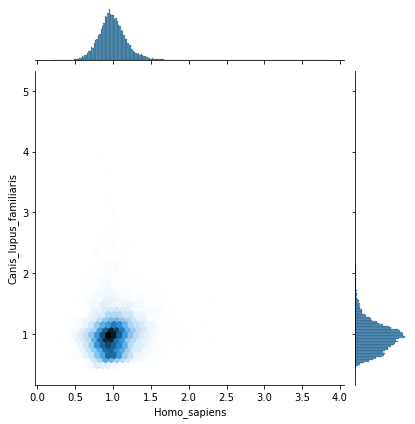

In [358]:
sns.jointplot(data=sq_subclass_rates,x="Homo_sapiens",y="Canis_lupus_familiaris",kind="hex")

In [134]:
sp1,sp2 = "Bos_taurus","Homo_sapiens"
subd1 = extract_sp_class(subclass_rates, sp1, "X>X", "X")
subd2 = extract_sp_class(subclass_rates, sp2, "X>X", "X")

In [139]:
species = subclass_rates.species.unique()

In [259]:
results = []
for pair in itertools.permutations(species,2):
    sp1,sp2 = pair
    subd1 = extract_sp_class(subclass_rates, sp1, "X>X", "A")
    subd2 = extract_sp_class(subclass_rates, sp2, "X>X", "A")
    r,pval = stats.pearsonr(subd1.rate, subd2.rate)
    results.append([sp1,sp2,r,pval])

In [260]:
results_df = pd.DataFrame(results)
results_df.columns = ["sp1","sp2","r","pval"]
results_df["log_pval"] = np.log10(results_df["pval"])

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


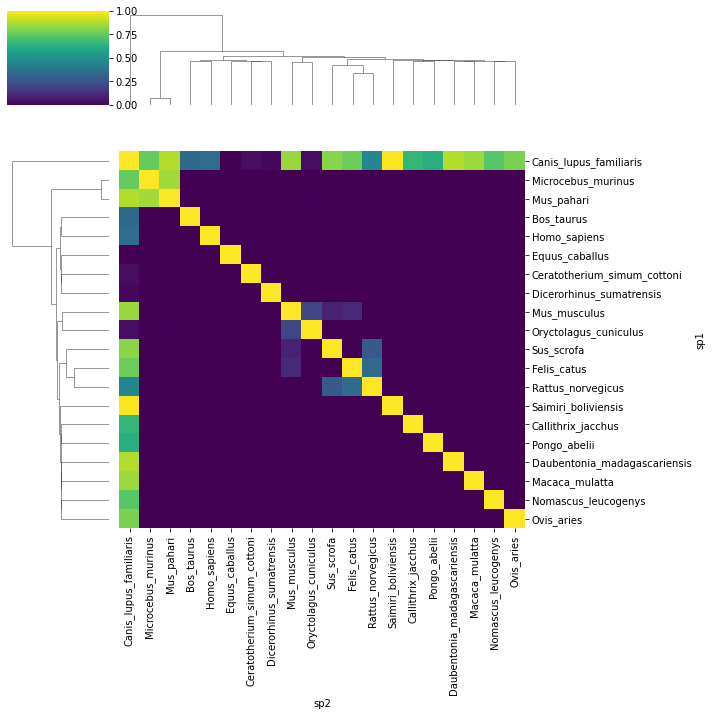

In [262]:
#f,ax = plt.subplots(figsize=[7,7])
sns.clustermap(results_df.pivot(index="sp1",columns="sp2",values="pval").fillna(1),cmap="viridis")
plt.tight_layout()
#plt.savefig("pdfs/Correlations_between_subrates_spearman.pdf")

(0.0, 2.5)

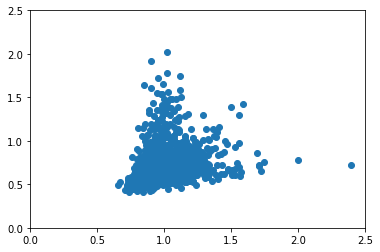

In [201]:
f,ax = plt.subplots()
subd1 = extract_sp_class(subclass_rates, "Saimiri_boliviensis", "X>X", "A")
subd2 = extract_sp_class(subclass_rates, "Canis_lupus_familiaris", "X>X", "A")
ax.scatter(subd1.norm_rate,subd2.norm_rate)
ax.set_ylim([0,2.5])
ax.set_xlim([0,2.5])

In [263]:
sq_rates = pd.DataFrame([rates_from_tree(tree) for tree in rates.tree])

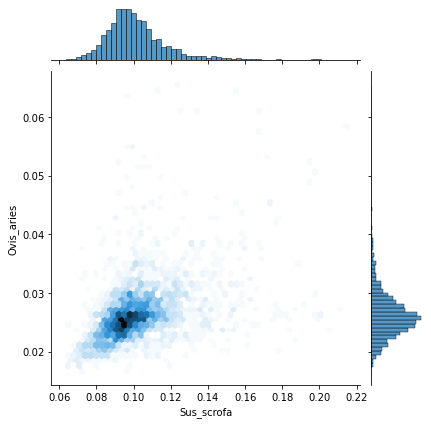

In [267]:
sns.jointplot(data=sq_rates,x=sp1,y=sp2,kind="hex")

GRAVEYARD

In [5]:
types = [c.split("_")[-1] for c in rates.columns if "tree_" in c and "var" not in c and ">" in c]
subs_df = pd.DataFrame()

for i,r in rates.iterrows():
    for mut in types:
        substitutions = rates_from_tree(r["tree_{}".format(mut)])
        n = len(substitutions)
        df = pd.DataFrame([list(substitutions.keys()), 
                           list(substitutions.values()),
                           [mut]*n,
                           ["A" if r.chrom!=chrX else "X"]*n,
                           [r["size"]]*n
                          ]
                         ).transpose()
        df.columns = ["species","n_subs", "mut", "chrom", "size"]
        subs_df = pd.concat([subs_df, df])

In [9]:
#subs_df["rate"] = subs_df.n_subs/subs_df.size

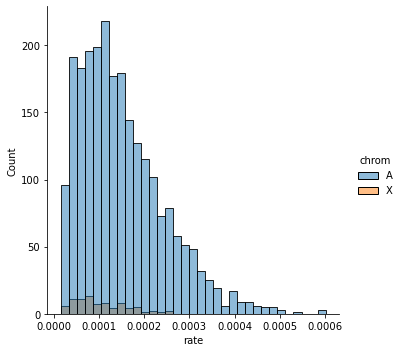

In [17]:
sp = "Microcebus_murinus"
sns.displot(data=subs_df[(subs_df.species==sp) & (subs_df.mut=="T>A")], x="rate", hue="chrom")

In [278]:
collapsed = subs_df.groupby(["species", "mut"])["n_subs"].sum().reset_index()

In [279]:
substrate_dict = collapsed[collapsed.mut.isin(["T","C"])].set_index(["species","mut"]).to_dict()["n_subs"]

In [280]:
mtypes = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
rates = []
for i,r in collapsed.iterrows():
    substrate = substrate_dict[(r.species,r.mut.split(">")[0])]
    rates.append(r.n_subs/substrate)

In [281]:
collapsed["rate"] = rates

In [282]:
#collapsed_mtype_counts = subs_df.groupby(["species", "mut"])["n_subs"].sum().reset_index()
#total_counts = collapsed_mtype_counts.groupby("species")["n_subs"].sum().to_dict()
#collapsed_mtype_counts["norm_subs"] = [r.n_subs/total_counts[r.species] for i,r in collapsed_mtype_counts.iterrows()]

In [283]:
alpha = pd.read_csv("../data/XA_2exposure-model_alphas.csv")
sp2alpha = alpha[["species","predicted_alpha"]].set_index("species").to_dict()["predicted_alpha"]
collapsed["alpha"] = [sp2alpha[sp] for sp in collapsed.species]

Comparing two mutation types (ratio)

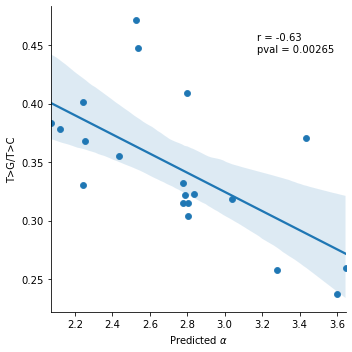

In [297]:
m1 = "T>G"
m2 = "T>C"
subd1 = collapsed[(collapsed["mut"]==m1)]# & (~collapsed_mtype_counts.species.isin(["Felis_catus","Canis_lupus_familiaris"]))]
subd2 = collapsed[(collapsed["mut"]==m2)]# & (~collapsed_mtype_counts.species.isin(["Felis_catus","Canis_lupus_familiaris"]))]
y = subd1.rate.values/subd2.rate.values
x = subd1.alpha

f,ax = plt.subplots(figsize=[5,5])
p = stats.pearsonr(x,y)
r,pval = p[0],p[1]

sns.scatterplot(x=x, y=y)
sns.regplot(x=x, y=y)
ax.text(0.7,0.85,"r = {:.2f}\npval = {:.5f}".format(r, pval),transform = ax.transAxes)
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel("{}/{}".format(m1,m2))
sns.despine()
plt.tight_layout()
#f.savefig("pdfs/{}_{}_alpha.pdf".format(m1,m2))

Just one mutation type

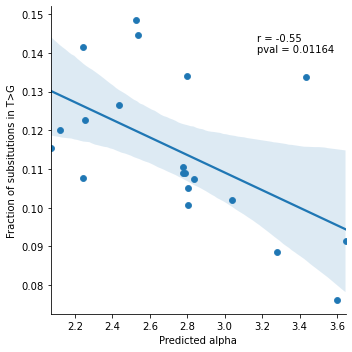

In [201]:
m = "T>G"
subd = collapsed_mtype_counts[(collapsed_mtype_counts["mut"]==m)]

x = subd.alpha
y = subd.norm_subs

f,ax = plt.subplots(figsize=[5,5])
sns.scatterplot(x=x, y=y)
sns.regplot(x=x, y=y)
p = stats.pearsonr(x,y)
r,pval = p[0],p[1]
ax.text(0.7,0.85,"r = {:.2f}\npval = {:.5f}".format(r, pval),transform = ax.transAxes)
ax.set_xlabel("Predicted alpha")
ax.set_ylabel("Fraction of subsitutions in {}".format(m))
sns.despine()
plt.tight_layout()
#f.savefig("pdfs/{}_alpha.pdf".format(m1))

All mutation types

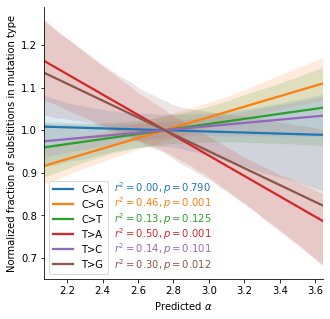

In [248]:
f,ax = plt.subplots(figsize=[5,5])
for i,(mut,df) in enumerate(collapsed_mtype_counts.groupby("mut")):
    x = df.alpha
    y = df.norm_subs
    y = y/y.mean()
    p = stats.pearsonr(x,y)
    r,pval = p[0],p[1]
    sns.regplot(x=x, y=y,ax=ax,scatter=False,label=mut)
    ax.text(0.25,0.32-(i/float(17.7)),r"$r^2 = {:.2f}, p = {:.3f}$".format(r**2, pval),transform = ax.transAxes,color="C{}".format(i))
ax.legend()
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel("Normalized fraction of subsititions in mutation type")
sns.despine()
#f.savefig("pdfs/Mtypes_vs_alpha.pdf")